In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell

# Hyperparameters

In [2]:
train_length = 1000
test_length = 1500

discount_rate = 0.995
rnn_size = 10

sampling_rate = 200
striding = 100

In [3]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def dataload(patient_number, dataset_number):
    try :
        input_folder_path = '/home/maestroj/medical_analysis/eeg_csv'
        input_data_name = 'data{}_{}.csv'.format(patient_number,dataset_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [5]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

# Onset-time data

In [6]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [7]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1

for p in range(total_patient):
    temp = []
    for d in range(event_number[p]):
        temp.append(seizure_time_parser(onset_times_temp,p+1,d+1))
    onset_times.append(temp)

In [8]:
print("The number of datasets of patients")
print(event_number)
print("1st patient's seizure time for each data_set")
print(onset_times[0][1])
print("9th patient's seizure time for each data_set")
print(onset_times[8])

The number of datasets of patients
[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]
1st patient's seizure time for each data_set
[781]
9th patient's seizure time for each data_set
[array([200]), array([312]), array([624]), array([762]), array([752]), array([772]), array([884]), array([502]), array([ 94, 258]), array([836]), array([650]), array([636]), array([576]), array([656]), array([638]), array([706])]


In [9]:
temp = dataload(1,1)
print(temp.shape)
result = downgrade_and_feature(temp)
print(result['averages'].shape)
print(result['variations'].shape)
time = time_axis_maker(result['averages'], striding/sampling_rate)

data1_1.csv is loaded
(22, 315200)
(3152,)
(3152,)


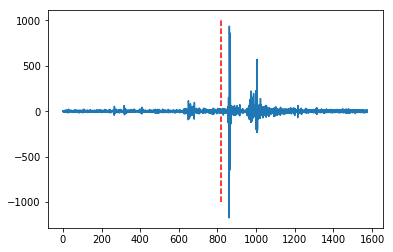

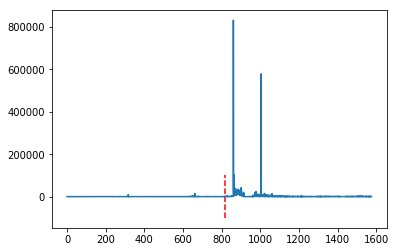

In [10]:
plt.plot(time, result['averages'])
plt.vlines(onset_times[0][0], -1000, 1000, colors='r', linestyles='--')
plt.show()

plt.plot(time, result['variations'])
plt.vlines(onset_times[0][0], -100000, 100000, colors='r', linestyles='--')
plt.show()

# Training_set

In [11]:
def train_set_generator(patient_number, dataset_number):
    
    result = downgrade_and_feature(dataload(patient_number,dataset_number))
    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        

    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    onset_time_temp = onset_time_temp[0]
    
    if onset_time_temp*sampling_rate/striding < train_length:
        print("Wrong input")
        return
    
    input_data = np.zeros((2,train_length))
    output_data = np.zeros(train_length)
    
    for i in range(train_length):
        if i==0:
            output_data[train_length-1] = 1
        else :
            output_data[train_length-1-i] = discount_rate*output_data[train_length-i] 

    onset_on_array = int(onset_time_temp*sampling_rate/striding)
    
    for i in range(train_length):
        input_data[0][i] = result['averages'][onset_on_array-train_length+1+i]
        input_data[1][i] = result['variations'][onset_on_array-train_length+1+i]

    return {'input' : input_data, 'output' : output_data}

data1_1.csv is loaded


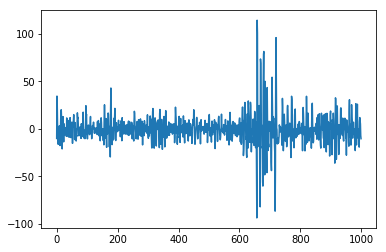

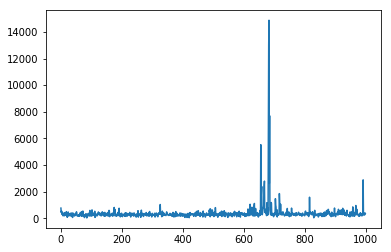

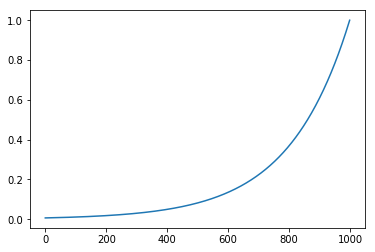

(2, 1000)
(1000,)


In [12]:
result = train_set_generator(1,1)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

data1_3.csv is loaded


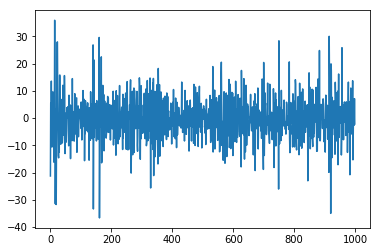

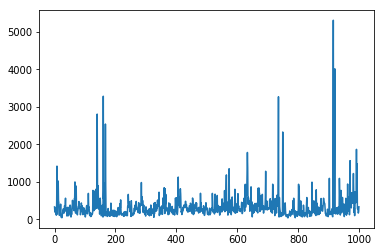

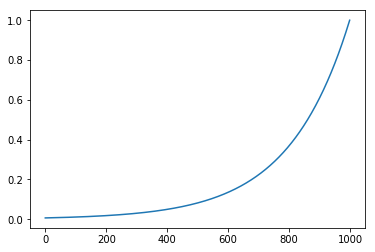

(2, 1000)
(1000,)


In [13]:
result = train_set_generator(1,3)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

# Neural network

In [14]:
x = tf.placeholder(tf.float32, shape=[2,train_length])
y = tf.placeholder(tf.float32, shape=[train_length])
test_x = tf.placeholder(tf.float32, shape=[2,test_length])

rnn_tei_x = tf.transpose(test_x,[1,0])
rnn_tei_x = tf.split(0,test_length,rnn_tei_x)

rnn_tri_x = tf.transpose(x,[1,0])
rnn_tri_x = tf.split(0,train_length,rnn_tri_x)

with tf.variable_scope("rnn") as scope:
    lstm_cell = rnn_cell.LSTMCell(rnn_size)

    W = tf.Variable(tf.truncated_normal([rnn_size,1], stddev=0.01))
    b = tf.Variable(tf.constant(0.01, shape=[1]))
    
    initial_state = lstm_cell.zero_state(1, tf.float32)
    
    outputs, states = rnn.rnn(lstm_cell, inputs = rnn_tri_x, initial_state = initial_state, dtype=tf.float32)
    temp_outputs = tf.pack(outputs)
    temp_outputs = tf.reshape(temp_outputs,[-1,rnn_size])
    temp_outputs = tf.matmul(temp_outputs,W)+b
    print(temp_outputs)
    
    scope.reuse_variables()
    test_outputs, test_states = rnn.rnn(lstm_cell, inputs = rnn_tei_x, initial_state = initial_state, dtype =tf.float32)
    temp_test_outputs = tf.pack(test_outputs)
    temp_test_outputs = tf.reshape(temp_test_outputs, [-1,rnn_size])
    temp_test_outputs = tf.matmul(temp_test_outputs,W)+b
    print(temp_test_outputs)
    temp_y = tf.reshape(y, [-1,1])
    print(temp_y)
    
    


Tensor("rnn/add:0", shape=(1000, 1), dtype=float32)
Tensor("rnn/add_1:0", shape=(1500, 1), dtype=float32)
Tensor("rnn/Reshape_2:0", shape=(1000, 1), dtype=float32)


In [15]:
cost = tf.reduce_sum(tf.square(temp_outputs-temp_y))
train = tf.train.AdamOptimizer(1e-3).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_set = []
temp_train_data_set = [1,6,8,9,10,11,12,14,15,16,17,18]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,8,9,10,16,17]
train_data_set.append(temp_train_data_set)
print(train_data_set)

Patient 1 and dataset 1
data1_1.csv is loaded


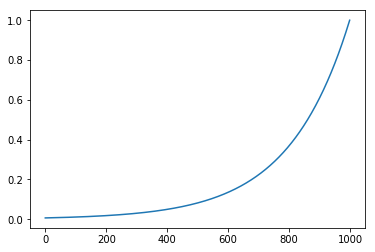

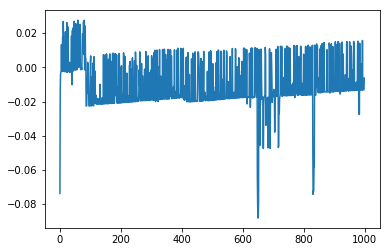

Before Cost = 104.48560333251953
After Cost = 61.097442626953125


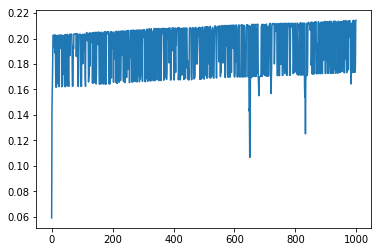

Patient 1 and dataset 2
data1_2.csv is loaded


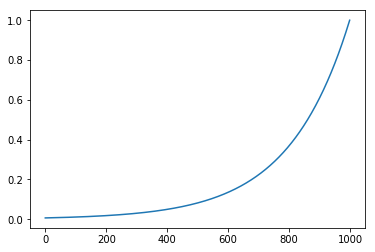

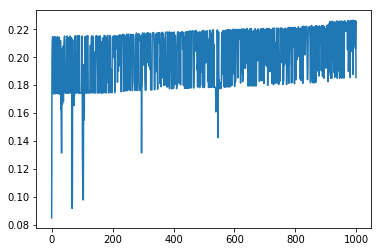

Before Cost = 58.49713897705078
After Cost = 63.2744140625


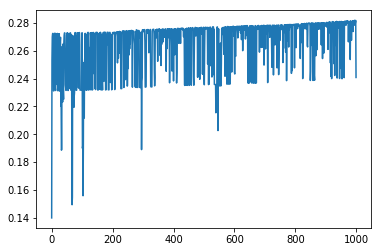

Patient 1 and dataset 3
data1_3.csv is loaded


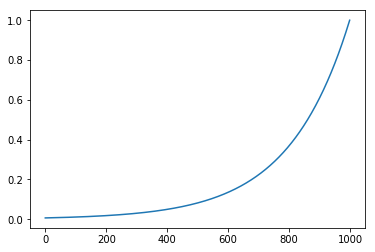

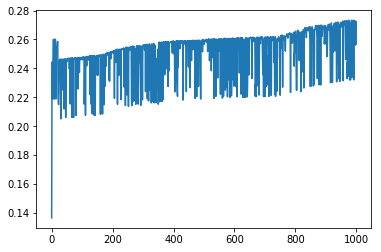

Before Cost = 61.1121940612793
After Cost = 57.75157165527344


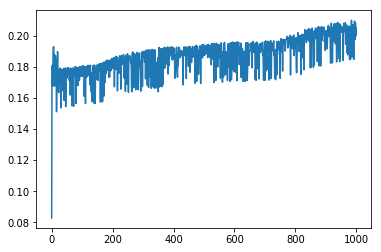

Patient 1 and dataset 4
data1_4.csv is loaded


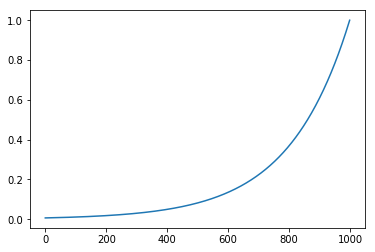

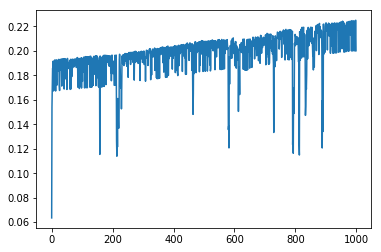

Before Cost = 57.37751007080078
After Cost = 55.730186462402344


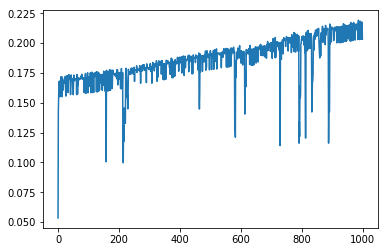

Patient 1 and dataset 5
data1_5.csv is loaded


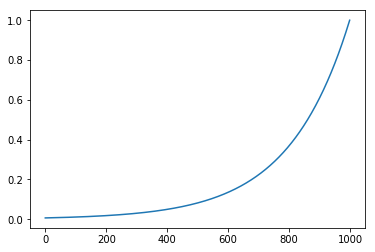

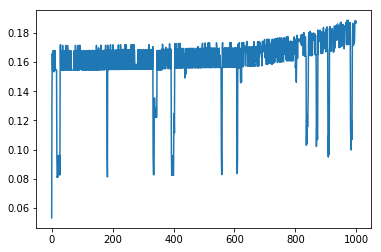

Before Cost = 59.91252136230469
After Cost = 57.14152526855469


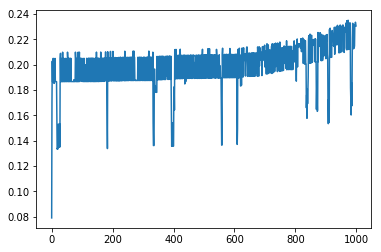

Patient 1 and dataset 6
data1_6.csv is loaded


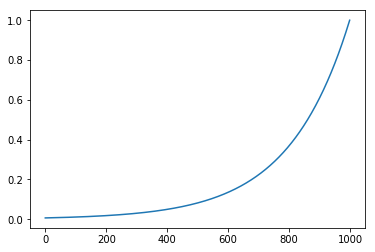

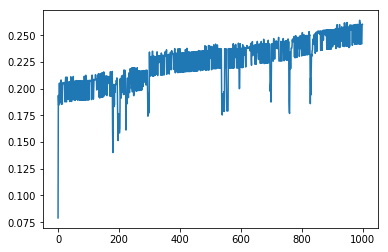

Before Cost = 54.92339324951172
After Cost = 52.38276672363281


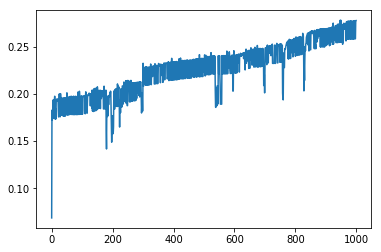

Patient 1 and dataset 7
data1_7.csv is loaded


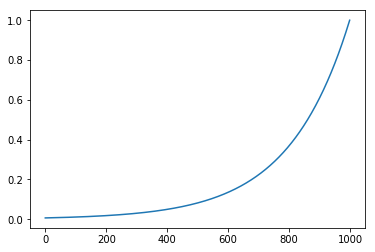

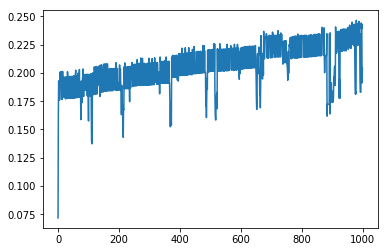

Before Cost = 56.80671691894531
After Cost = 48.408782958984375


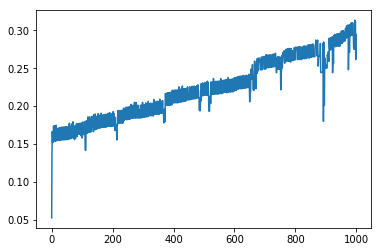

Patient 2 and dataset 1
data2_1.csv is loaded


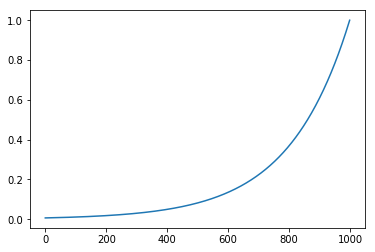

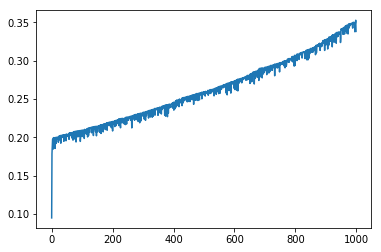

Before Cost = 47.384124755859375
After Cost = 19.718204498291016


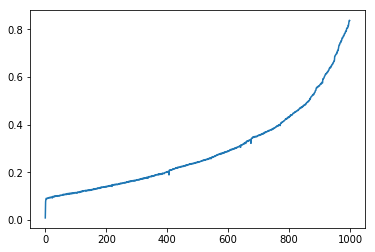

Patient 2 and dataset 2
data2_2.csv is loaded


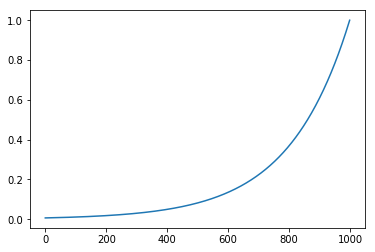

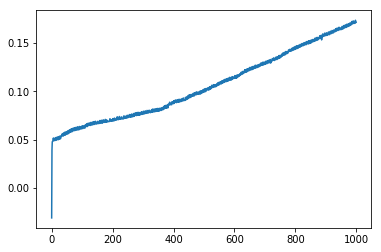

Before Cost = 54.94712448120117
After Cost = 91.09709930419922


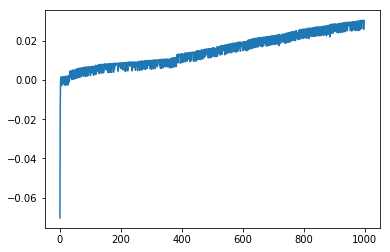

Patient 2 and dataset 3
data2_3.csv is loaded


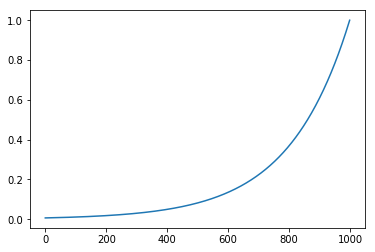

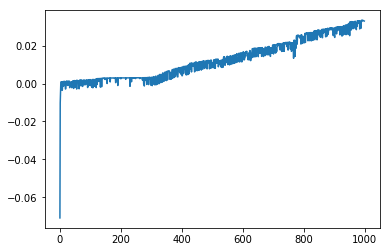

Before Cost = 90.95520782470703
After Cost = 63.21243667602539


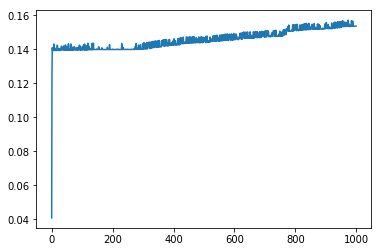

Patient 2 and dataset 4
data2_4.csv is loaded


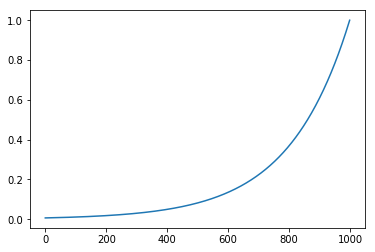

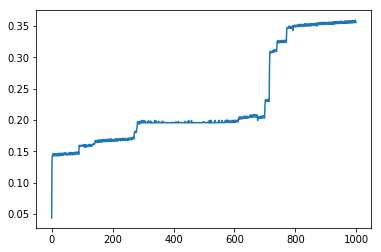

Before Cost = 33.76075744628906
After Cost = 34.85232162475586


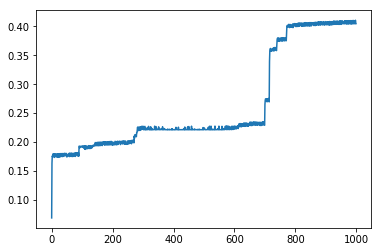

Patient 2 and dataset 5
data2_5.csv is loaded


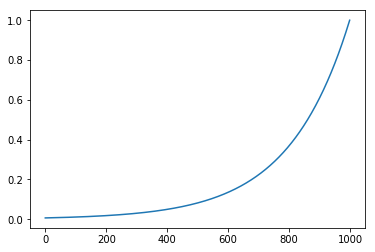

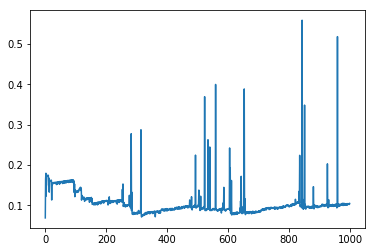

Before Cost = 72.01467895507812
After Cost = 41.63713073730469


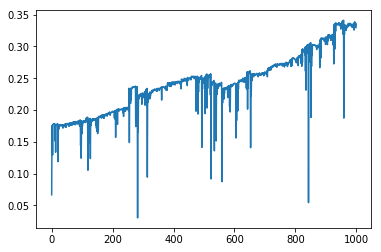

Patient 2 and dataset 6
data2_6.csv is loaded


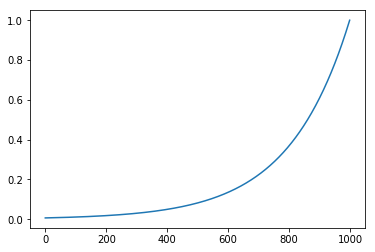

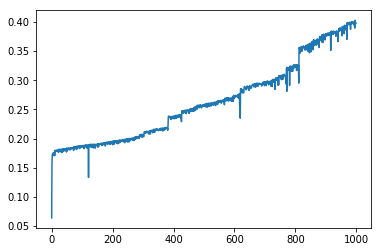

Before Cost = 38.514076232910156
After Cost = 25.832355499267578


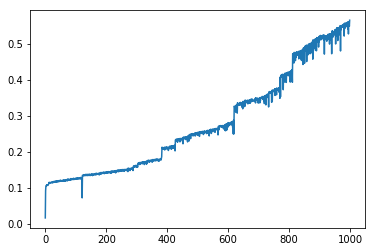

Patient 2 and dataset 7
data2_7.csv is loaded


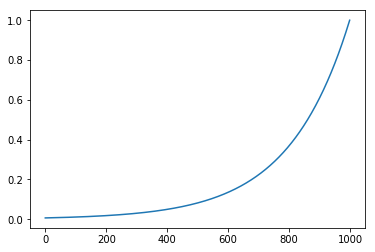

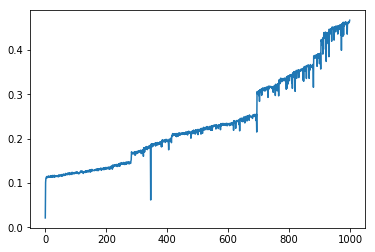

Before Cost = 25.184661865234375
After Cost = 15.270708084106445


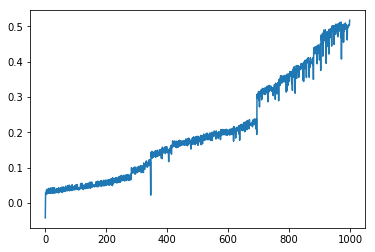

Patient 3 and dataset 1
data3_1.csv is loaded


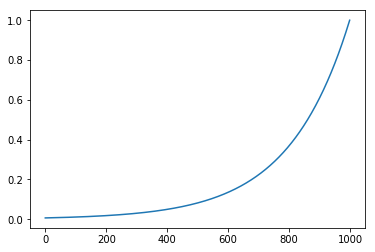

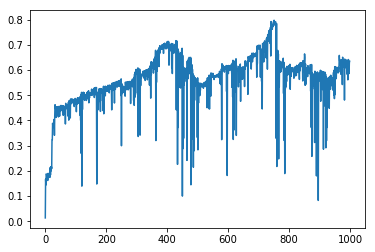

Before Cost = 189.92266845703125
After Cost = 90.74248504638672


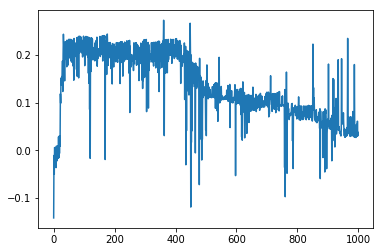

Patient 3 and dataset 5
data3_5.csv is loaded


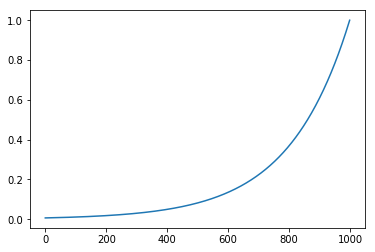

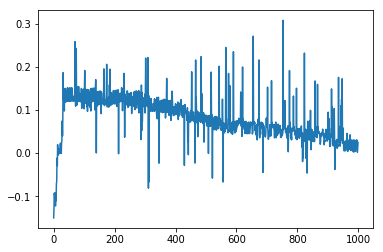

Before Cost = 89.83612060546875
After Cost = 77.84767150878906


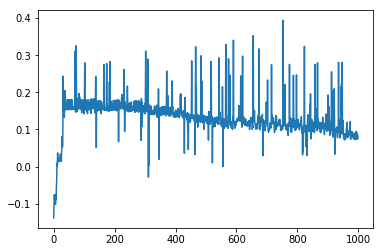

Patient 3 and dataset 6
data3_6.csv is loaded


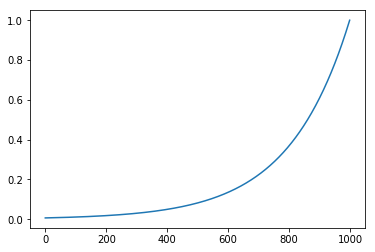

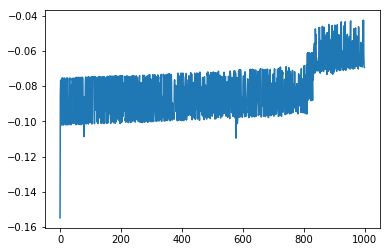

Before Cost = 135.4986572265625
After Cost = 74.36436462402344


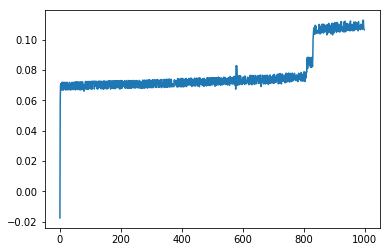

Patient 4 and dataset 1
data4_1.csv is loaded


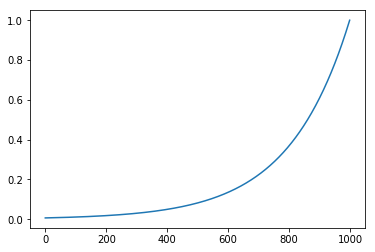

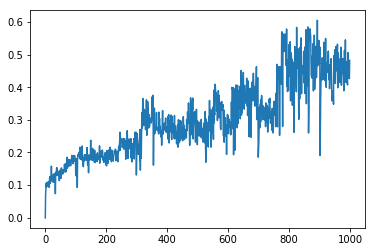

Before Cost = 40.8288459777832
After Cost = 28.37281036376953


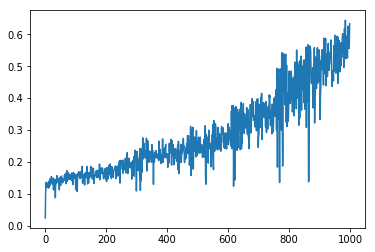

Patient 4 and dataset 2
data4_2.csv is loaded


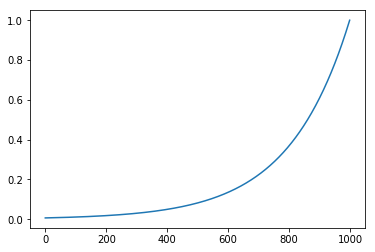

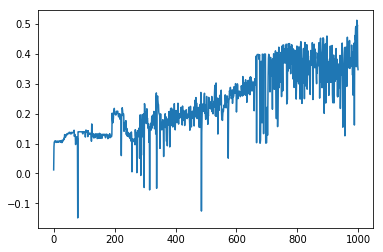

Before Cost = 35.03593826293945
After Cost = 16.99388313293457


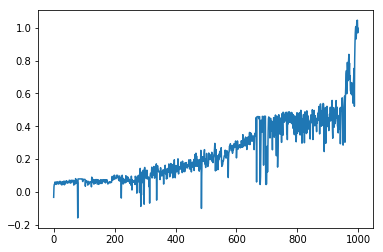

Patient 4 and dataset 3
data4_3.csv is loaded


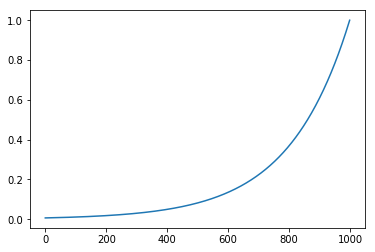

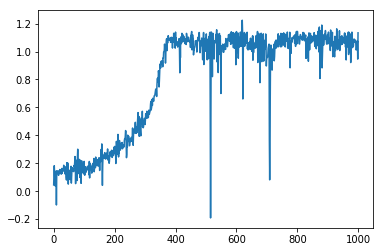

Before Cost = 459.19189453125
After Cost = 120.41029357910156


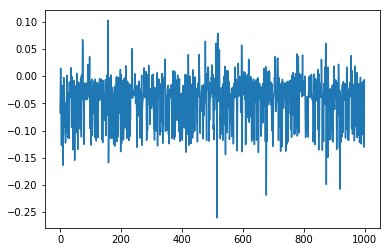

Patient 5 and dataset 2
data5_2.csv is loaded


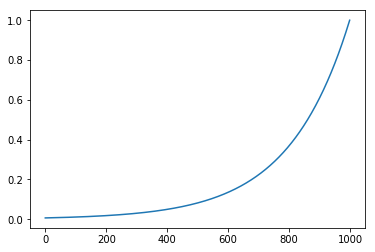

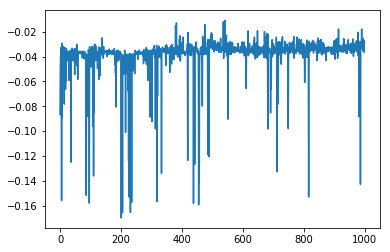

Before Cost = 116.15972900390625
After Cost = 81.6177978515625


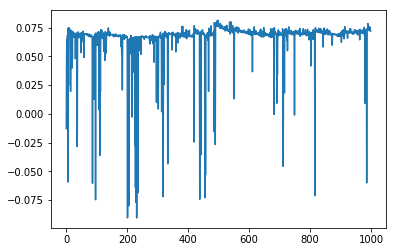

Patient 5 and dataset 3
data5_3.csv is loaded


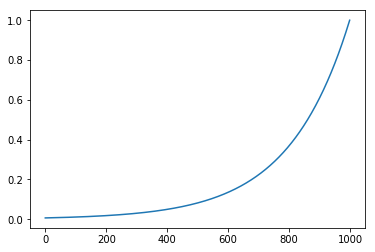

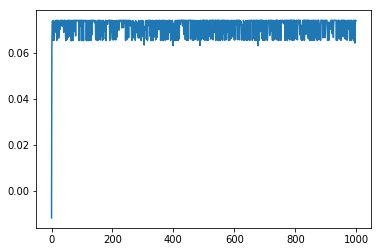

Before Cost = 77.06607055664062
After Cost = 61.775848388671875


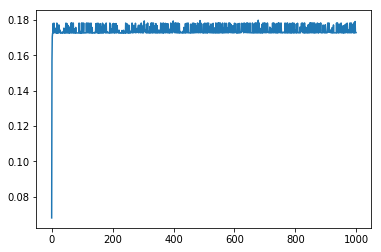

Patient 5 and dataset 4
data5_4.csv is loaded


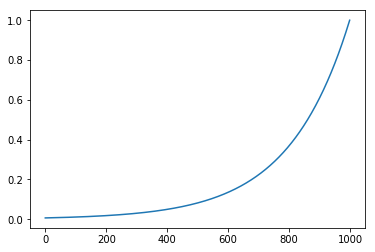

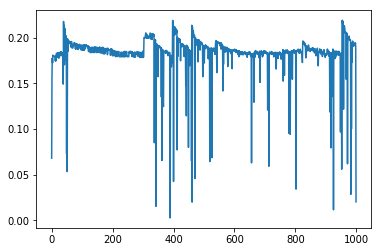

Before Cost = 62.47607421875
After Cost = 62.78894805908203


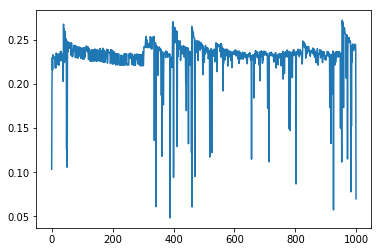

Patient 6 and dataset 1
data6_1.csv is loaded


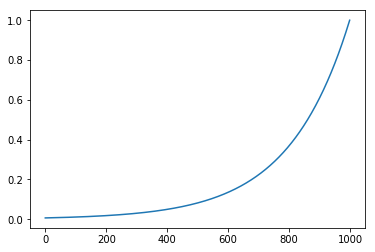

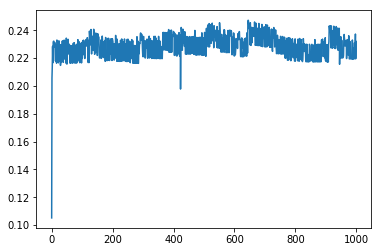

Before Cost = 61.85085678100586
After Cost = 61.82395935058594


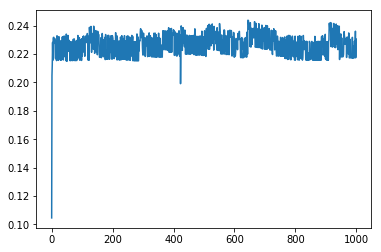

Patient 7 and dataset 1
data7_1.csv is loaded


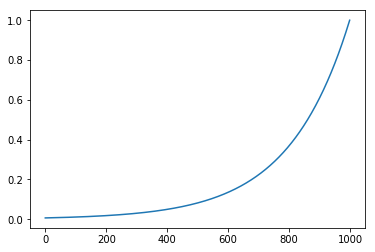

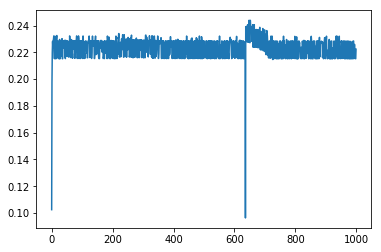

Before Cost = 61.80231475830078
After Cost = 61.22633743286133


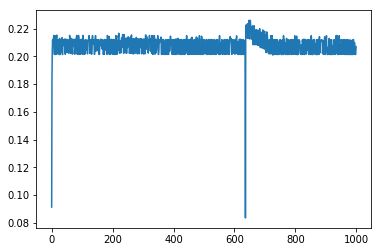

Patient 7 and dataset 2
data7_2.csv is loaded


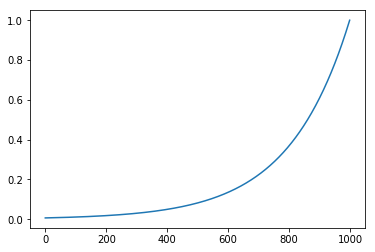

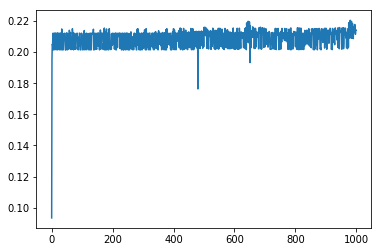

Before Cost = 60.32341766357422
After Cost = 60.253849029541016


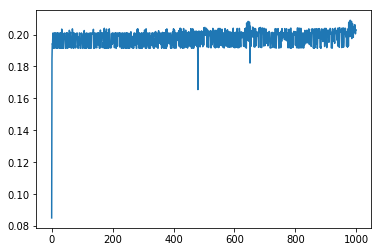

Patient 7 and dataset 3
data7_3.csv is loaded


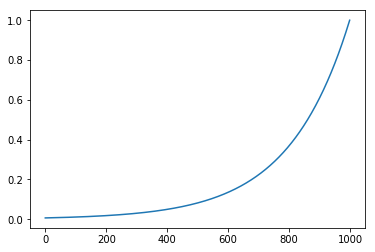

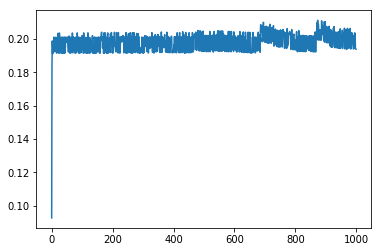

Before Cost = 60.2320556640625
After Cost = 59.877193450927734


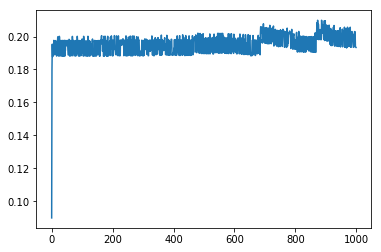

Patient 7 and dataset 4
data7_4.csv is loaded


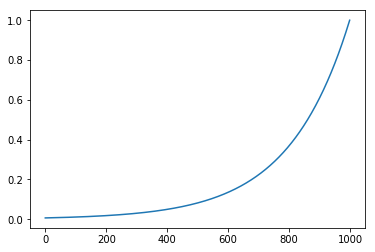

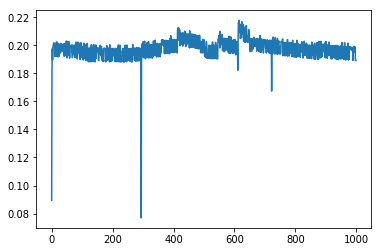

Before Cost = 60.949405670166016
After Cost = 60.291175842285156


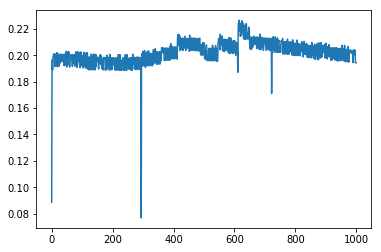

Patient 7 and dataset 5
data7_5.csv is loaded


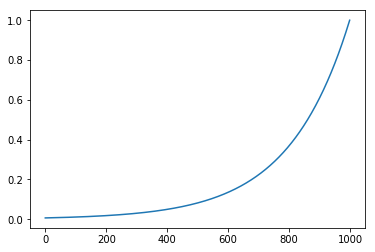

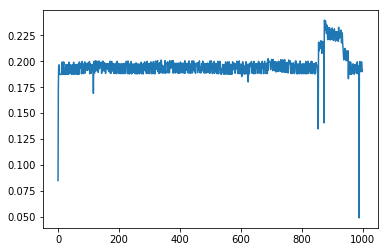

Before Cost = 59.01675033569336
After Cost = 57.250328063964844


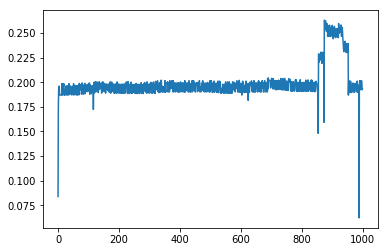

Patient 7 and dataset 6
data7_6.csv is loaded


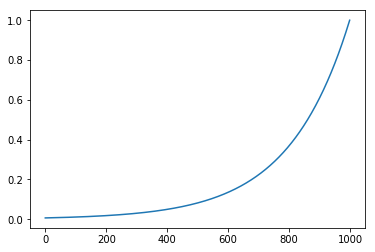

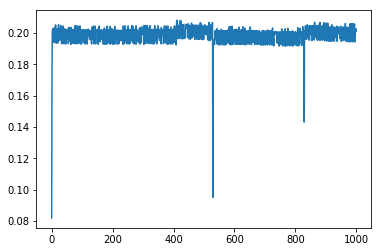

Before Cost = 60.59160614013672
After Cost = 59.81421661376953


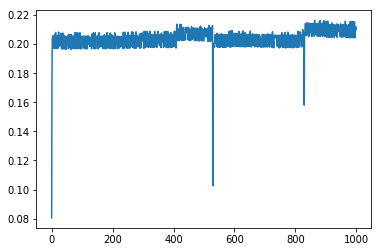

Patient 7 and dataset 7
data7_7.csv is loaded


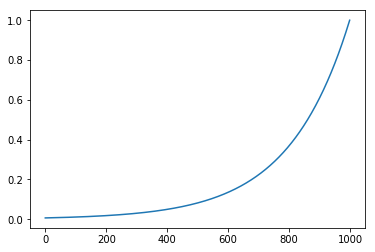

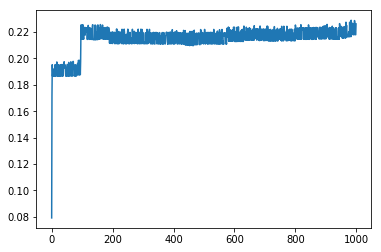

Before Cost = 59.55205154418945
After Cost = 58.10802459716797


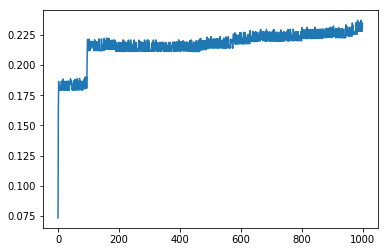

Patient 8 and dataset 1
data8_1.csv is loaded


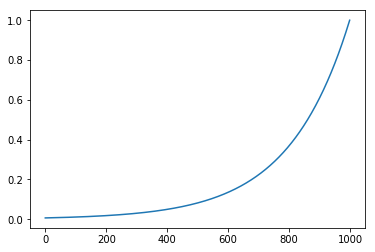

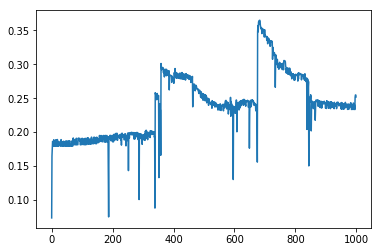

Before Cost = 57.768707275390625
After Cost = 53.810054779052734


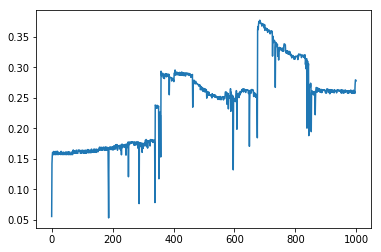

Patient 8 and dataset 2
data8_2.csv is loaded


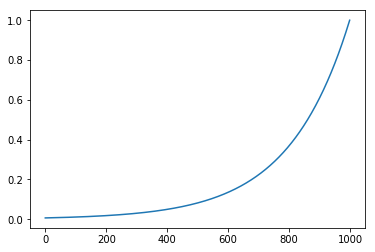

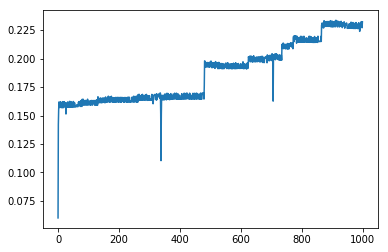

Before Cost = 50.44751739501953
After Cost = 31.88189697265625


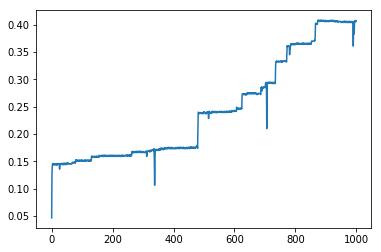

Patient 8 and dataset 3
data8_3.csv is loaded


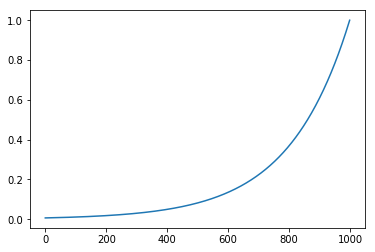

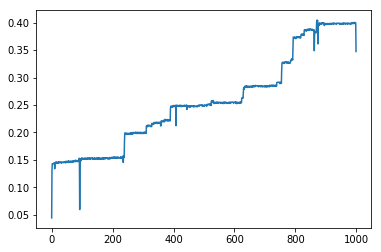

Before Cost = 33.96918487548828
After Cost = 32.51842498779297


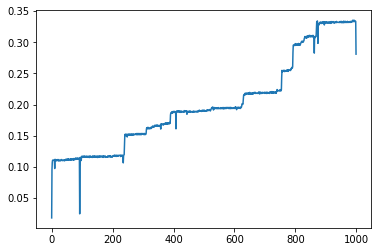

Patient 8 and dataset 4
data8_4.csv is loaded


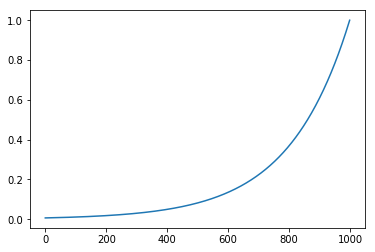

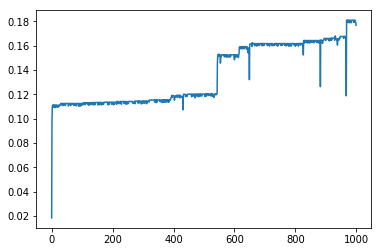

Before Cost = 55.52242660522461
After Cost = 47.95500946044922


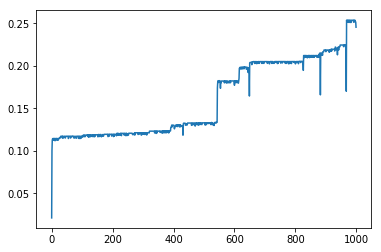

Patient 8 and dataset 5
data8_5.csv is loaded


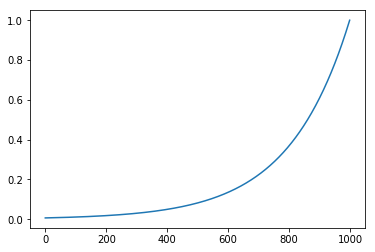

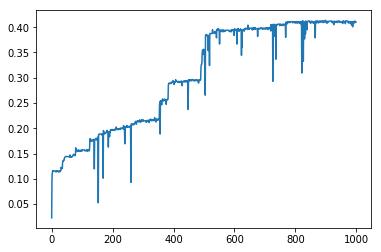

Before Cost = 47.80379867553711
After Cost = 33.246726989746094


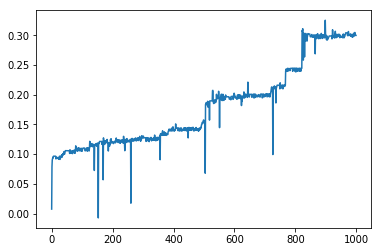

Patient 8 and dataset 6
data8_6.csv is loaded


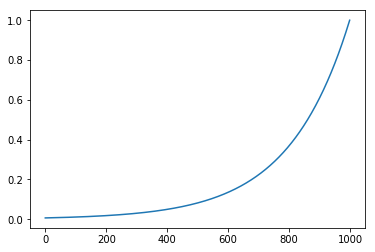

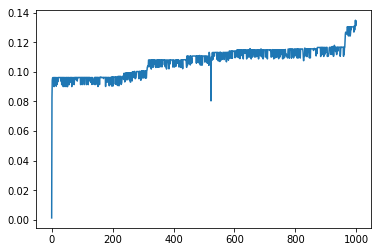

Before Cost = 65.81900024414062
After Cost = 62.36683654785156


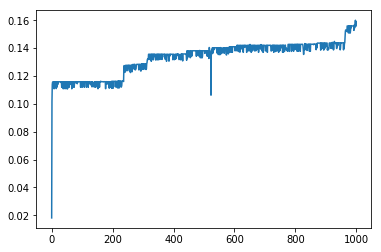

Patient 8 and dataset 7
data8_7.csv is loaded


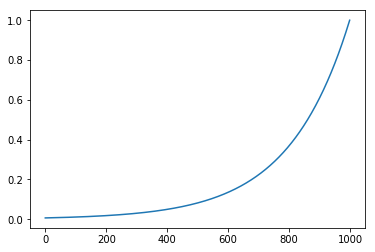

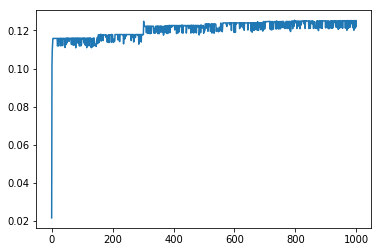

Before Cost = 65.79638671875
After Cost = 60.307823181152344


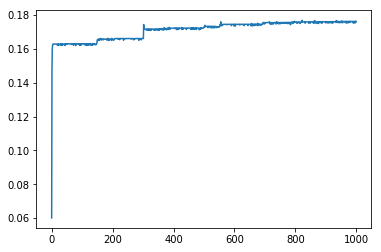

Patient 8 and dataset 9
data8_9.csv is loaded


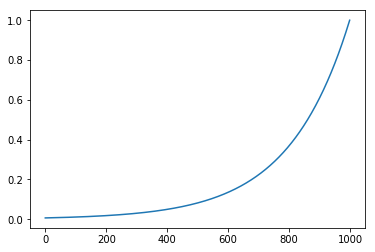

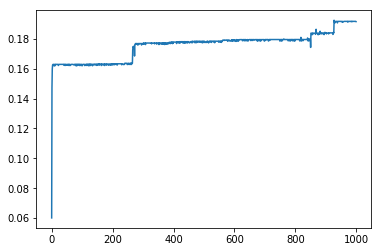

Before Cost = 58.16960144042969
After Cost = 56.64930725097656


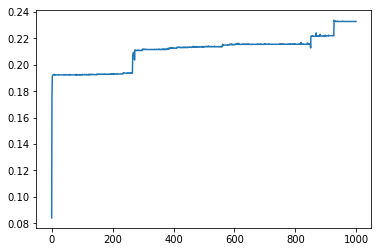

Patient 8 and dataset 10
data8_10.csv is loaded


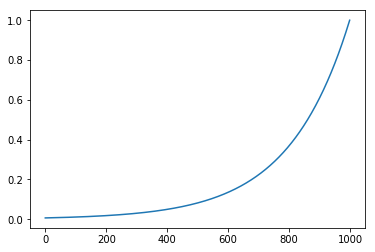

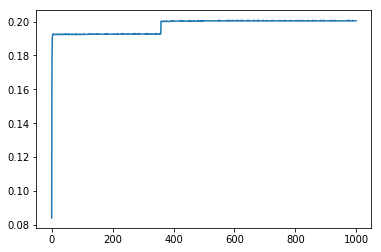

Before Cost = 59.727394104003906
After Cost = 59.54938888549805


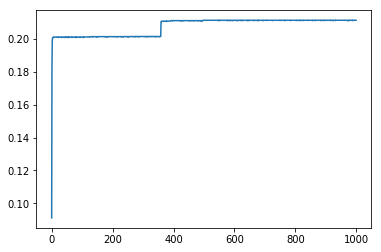

Patient 8 and dataset 11
data8_11.csv is loaded


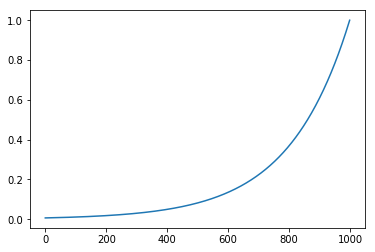

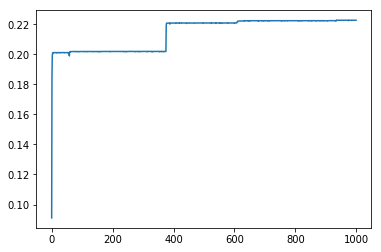

Before Cost = 58.19054412841797
After Cost = 57.22586441040039


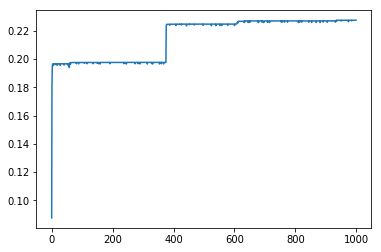

Patient 8 and dataset 12
data8_12.csv is loaded


In [ ]:
iteration=100
for s in range(iteration):
    for i in range(len(onset_times)):
        for j in range(len(onset_times[i])):
            if len(onset_times[i][j])>1:
                continue;
            onset_time_temp = onset_times[i][j][0]
            if onset_time_temp*sampling_rate/striding < train_length:
                continue;
            print("Patient {} and dataset {}".format(i+1,j+1))
            result = train_set_generator(i+1, j+1)
            input_data = result['input']
            output_data = result['output']
            plt.plot(output_data)
            plt.show()
            plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
            plt.show()
            for k in range(10):
                opt, c = sess.run([train, cost], feed_dict={x: input_data, y: output_data})
                if k==0:
                    print("Before Cost = {}".format(c))
            print("After Cost = {}".format(c))
            plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
            plt.show()

In [ ]:
tf.add_to_collection('test_input', test_x)
tf.add_to_collection('hypothesis', temp_test_outputs)
saver = tf.train.Saver()
saver.save(sess,'rnn_v5')